/home/puripat/.local/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/puripat/.local/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


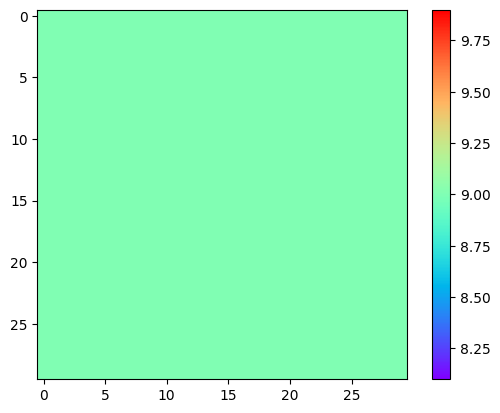

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import itertools as itr
from boundaries import WallBoundary, PressureBoundary, VelocityBoundary
from generators import WallGenerators

# Initializing a rank three tensor filled with nodes
latticeSize = 9
xResolution = 30
yResolution = 30
relaxationTime = 0.809 # Best: 0.809
# Weights
unitVect = np.array(
    [[0, 0], [1, 0], [0, 1], [-1, 0], [0, -1], [1, 1], [-1, 1], [-1, -1], [1, -1]]
)
unitX = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
unitY = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
weight = np.array([4 / 9, 1 / 9, 1 / 9, 1 / 9, 1 / 9, 1 / 36, 1 / 36, 1 / 36, 1 / 36])
cs = np.sqrt(3)

# Initializing the fluid matrix
fluid = np.ones(
    (xResolution, yResolution, latticeSize)
)  # + 0.1 * np.random.randn(xResolution, yResolution, latticeSize)
# fluid[:, 1, 1] = 3
fluid = fluid.copy()

boundary = WallBoundary(xResolution, yResolution, False)
generators = WallGenerators(boundary)

# boundary.cylindricalWall([xResolution / 2, yResolution / 2], 6)
# boundary.borderWall()
# boundary.filledStraightRectangularWall([8, 15], [16, 0])
# boundary.filledStraightRectangularWall([16, 0], [29, 8])
# boundary.filledStraightRectangularWall([20, 29], [20, 25])
# boundary.filledStraightRectangularWall([0, 29], [10, 24])

# generators.generateRandomBlocks(6, 10)

pressureBoundaries = [PressureBoundary(20, 20, 2, 0, 3), PressureBoundary(20, 3, 2, 0, 1)]
velocityBoundaries = [] # [VelocityBoundary(3, 15, [4], [2])]

fluid[boundary.boundary, :] = 0

density = np.sum(fluid, axis=2)
momentumX = np.sum(fluid * unitX, axis=2)
momentumY = np.sum(fluid * unitY, axis=2)
speedX = momentumX / density
speedY = momentumY / density
speedX = np.nan_to_num(speedX, posinf=0, neginf=0, nan=0)
speedY = np.nan_to_num(speedY, posinf=0, neginf=0, nan=0)

X = np.arange(xResolution)
Y = np.arange(yResolution)

plt.quiver(X, Y, speedX, speedY)
plt.imshow(density, cmap="rainbow", interpolation="nearest")
plt.colorbar()
# plt.imshow(boundary.boundary, cmap = "gray", interpolation = "nearest")

In [81]:
def stepFluid(fluid):
    # Stabilizing Step
    density = np.sum(fluid, axis=2)
    speedX = np.sum(fluid * unitX, axis=2) / density
    speedY = np.sum(fluid * unitY, axis=2) / density
    speedX = np.nan_to_num(speedX, posinf=0, neginf=0, nan=0)
    speedY = np.nan_to_num(speedY, posinf=0, neginf=0, nan=0)

    # Equilizing step
    fluidEquilibrium = np.zeros(fluid.shape)
    for latticeIndex, cx, cy, w in zip(range(latticeSize), unitX, unitY, weight):
        fluidEquilibrium[:, :, latticeIndex] = (
            density
            * w
            * (
                1
                + 3 * (cx * speedX + cy * speedY)
                + 9 * (cx * speedX + cy * speedY) ** 2 / 2
                - 3 * (speedX**2 + speedY**2) / 2
            )
        )

    # fluid[boundary.invertedBoundary, :] -= (1 / relaxationTime) * (fluid[boundary.invertedBoundary, :] - fluidEquilibrium[boundary.invertedBoundary, :])
    fluid -= (1 / relaxationTime) * (fluid - fluidEquilibrium)

    for latticeIndex, shiftX, shiftY in zip(range(latticeSize), unitX, unitY):
        fluid[:, :, latticeIndex] = np.roll(fluid[:, :, latticeIndex], shiftX, axis=1)
        fluid[:, :, latticeIndex] = np.roll(fluid[:, :, latticeIndex], shiftY, axis=0)

    fluidBoundary = fluid[boundary.boundary, :]
    fluidBoundary = fluidBoundary[:, [0, 3, 4, 1, 2, 7, 8, 5, 6]]
    fluid[boundary.boundary, :] = fluidBoundary

    for pressureBoundary in pressureBoundaries:
        for latticeIndex in range(latticeSize):
            fluid[pressureBoundary.x, pressureBoundary.y, latticeIndex] = 0
        densityAtIndex = density[pressureBoundary.x, pressureBoundary.y]
        fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setIndices[0]] = fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getIndices[0]] + (2/3)*(pressureBoundary.mainVelocity)
        fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setIndices[1]] = fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getIndices[1]] - (0.5 * (fluid[pressureBoundary.x , pressureBoundary.y, (4 if pressureBoundary.direction - 1 == 0 else pressureBoundary.direction - 1)] - fluid[pressureBoundary.x , pressureBoundary.y, (1 if pressureBoundary.direction + 1 == 5 else pressureBoundary.direction + 1)])) + (0.5 * densityAtIndex * pressureBoundary.minorVelocity) + (1/6 * densityAtIndex * pressureBoundary.mainVelocity)
        fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.setIndices[2]] = fluid[pressureBoundary.x , pressureBoundary.y, pressureBoundary.getIndices[2]] + (0.5 * (fluid[pressureBoundary.x , pressureBoundary.y, (4 if pressureBoundary.direction - 1 == 0 else pressureBoundary.direction - 1)] - fluid[pressureBoundary.x , pressureBoundary.y, (1 if pressureBoundary.direction + 1 == 5 else pressureBoundary.direction + 1)])) - (0.5 * densityAtIndex * pressureBoundary.minorVelocity) + (1/6 * densityAtIndex * pressureBoundary.mainVelocity)
    
    for velocityBoundary in velocityBoundaries:
        fluid[velocityBoundary.x, velocityBoundary.y, velocityBoundary.magnitude] = velocityBoundary.direction
    
    return fluid

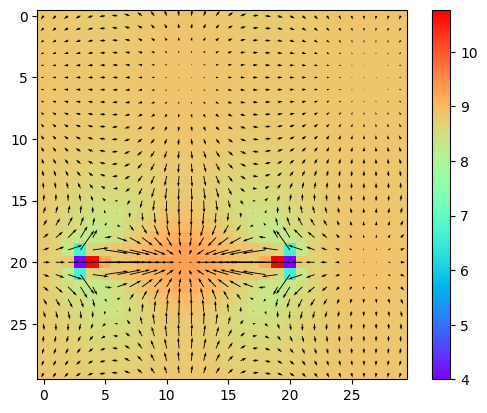

In [96]:
stepAmount = 10
for i in range(stepAmount):
	fluid = stepFluid(fluid)
iteratedDensity = np.sum(fluid, axis = 2)
iteratedMomentumX = np.sum(fluid * unitX, axis = 2)
iteratedMomentumY = np.sum(fluid * unitY, axis = 2) 
plt.quiver(X, Y, iteratedMomentumX, iteratedMomentumY)
plt.imshow(iteratedDensity, cmap = "rainbow", interpolation = "nearest")
plt.colorbar()

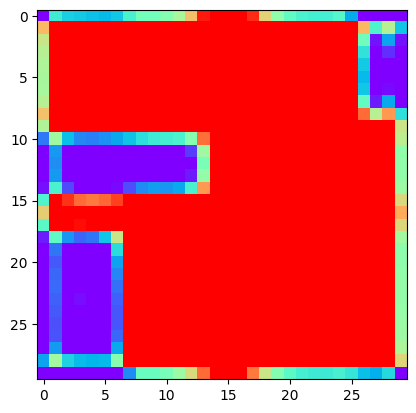

In [23]:
fig, ax = plt.subplots()
heatmap = ax.imshow(iteratedDensity, cmap="rainbow")

def update(frame):
    global fluid
    iterateAmount = 5
    for i in range(iterateAmount):
        fluid = stepFluid(fluid)
    iteratedDensity = np.sum(fluid, axis=2)
    heatmap.set_data(iteratedDensity)
    return heatmap,

ani = anim.FuncAnimation(fig, update, frames = 300, interval = 1, blit = True)
ani.save('fluidEvolution.mp4', writer = 'ffmpeg', fps = 30) 